<center> <h2>Home Work 2</h2> <br>
<h3> Piyush Khemka </h3>
<h3> SBU ID - 110828688 </h3>
</center>

### Imports and Reading file from CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import sklearn
from scipy.stats.stats import pearsonr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import pdist, squareform
from IPython.display import display, HTML
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

In [2]:
country = pd.read_csv("country-data.csv")
country.head()

,Country Name,Country Code,Government Type,Capital City,Date of Founding/Independence,Latitude of Capital,Longitude of Capital,Population,Life Expectancy,GDP (PPP) in US $,...,Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate
0,Afghanistan,AF,Islamic republic,Kabul,8/19/19,34 31 N,69 11 E,31822848,50.49,4.530000e+10,...,5987.0,0.0,28.1,9.6,4.74,65.33,-1.83,7512000,1000000,15
1,Albania,AL,parliamentary democracy,Tirana,11/28/12,41 19 N,19 49 E,3020209,77.96,2.834000e+10,...,691.0,362.0,96.8,6.3,1.47,41.7,-3.31,1098000,1300000,9.52
2,Algeria,DZ,republic,Algiers,7/5/62,36 45 N,3 03 E,38813722,76.39,2.847000e+11,...,6734.0,998.0,72.6,3.9,4.48,11.67,-0.93,11150000,4700000,8
3,Andorra,AD,parliamentary democracy,Andorra la Vella,1278,42 30 N,1 31 E,85458,82.65,3.163000e+09,...,118.0,0.0,100,7.2,unknown,unknown,0,36060,67100,unknown
4,Angola,AO,republic,Luanda,11/11/75,8 50 S,13 13 E,19088106,55.29,1.318000e+11,...,5369.0,1600.0,70.4,3.5,3.63,148,0.47,9018000,606700,15


### Data Cleaning

We can see the following problems with the given data which will require some cleaning up: 
- Many Numerical fields are object types (such as Literacy Rate)
- Lots of fields marked as Unknown. 
- Date of Independence is an object type and not a datetime field
- Government Type although descriptive has redundant information. To make it useful we will need to reduce it into simpler categories

In [3]:
# Replace all the unknowns in the file with NaN so that we can apply the operation dropna() on them
country.replace(to_replace="unknown",value=np.NaN,inplace=True)

# Convert all numeric columns which are of object types to float64 type
cols_to_convert = ["Literacy Rate (%)", "Health Expenditure/GDP", "Military Expenditure/GDP", 
                   "Renewable Water Resources (cu km)", "Net Migration Rate/1000 Population", 
                   "Labor Force","Internet Users (circa 2009)", "Commercial Prime Lending Rate"]

country[cols_to_convert] = country[cols_to_convert].apply(pd.to_numeric,errors="coerce")


###### To further clean up data, fill the NaNs with the medians of that columns

In [4]:
country["Literacy Rate (%)"].fillna((country["Literacy Rate (%)"].median()), inplace=True)
country["Health Expenditure/GDP"].fillna((country["Health Expenditure/GDP"].median()), inplace=True)
country["Military Expenditure/GDP"].fillna((country["Military Expenditure/GDP"].median()), inplace=True)
country["Renewable Water Resources (cu km)"].fillna((country["Renewable Water Resources (cu km)"].median()), inplace=True)
country["Net Migration Rate/1000 Population"].fillna((country["Net Migration Rate/1000 Population"].median()), inplace=True)
country["Labor Force"].fillna((country["Labor Force"].median()), inplace=True)
country["Internet Users (circa 2009)"].fillna((country["Internet Users (circa 2009)"].median()), inplace=True)
country["Commercial Prime Lending Rate"].fillna((country["Commercial Prime Lending Rate"].median()), inplace=True)

We subtract Date of Indepence from 2016 (Current year) and get the age of the country. This value is appended to the original table and will be utilized later for producing interesting data insights.

In [5]:
def makefourdigit(x):
    if len(str(x)) == 2:
        return ("19"+ x)
    elif len(str(x)) == 3:
        return ("1"+ x)
    else:
        return x

# Extract the right most part of the string after the last '/'
count = country["Date of Founding/Independence"].str.rpartition('/')[2] 
# Concat two digit strings with 19 and three digits with 1 to convert to a 4 digit year format
count = count.apply(makefourdigit)
count = count.apply(pd.to_numeric,errors="coerce")
# Age of country is defined as the number of years of the country since its independence
country["Age of Country"] = 2016-count
country["Age of Country"].fillna((country["Age of Country"].mean()), inplace=True)

Added a simplified government type
loosely inspired from this : http://depts.alverno.edu/dgp/GEC/Types%20of%20Government.html <br>

All the government types are now reudced to one of the following:
- Constitutional Monarchy,
- Democracy, (Since both Republics and Democratic nations vote to chose their leaders, they are represented under Democracy)
- Communist State 
- Dictatorship
- Others 

In [6]:
def gov(x):
    x = x.lower()
    if "monarchy" in x and "constitutional" in x:
        return ("Constitutional Monarchy")
    elif "monarchy" in x or "dictatorship" in x or "authoritarian" in  x or "emirate" in x or "sultanate" in x:
        return "Dictatorship"
    elif "communist" in x:
        return "Communist State"
    elif "democracy" in x or "republic" in x:
        return "Democracy"
    else:
        return "Others"

s = country["Government Type"]
s = s.apply(gov)
country["Simplified Government Type"] = s
country.head()

,Country Name,Country Code,Government Type,Capital City,Date of Founding/Independence,Latitude of Capital,Longitude of Capital,Population,Life Expectancy,GDP (PPP) in US $,...,Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate,Age of Country,Simplified Government Type
0,Afghanistan,AF,Islamic republic,Kabul,8/19/19,34 31 N,69 11 E,31822848,50.49,4.530000e+10,...,28.1,9.6,4.74,65.33,-1.83,7512000.0,1000000.0,15.00,97.0,Democracy
1,Albania,AL,parliamentary democracy,Tirana,11/28/12,41 19 N,19 49 E,3020209,77.96,2.834000e+10,...,96.8,6.3,1.47,41.70,-3.31,1098000.0,1300000.0,9.52,104.0,Democracy
2,Algeria,DZ,republic,Algiers,7/5/62,36 45 N,3 03 E,38813722,76.39,2.847000e+11,...,72.6,3.9,4.48,11.67,-0.93,11150000.0,4700000.0,8.00,54.0,Democracy
3,Andorra,AD,parliamentary democracy,Andorra la Vella,1278,42 30 N,1 31 E,85458,82.65,3.163000e+09,...,100.0,7.2,1.47,59.80,0.00,36060.0,67100.0,9.94,738.0,Democracy
4,Angola,AO,republic,Luanda,11/11/75,8 50 S,13 13 E,19088106,55.29,1.318000e+11,...,70.4,3.5,3.63,148.00,0.47,9018000.0,606700.0,15.00,41.0,Democracy


<center><h1> ------ </h1></center>
### (1) Produce five informative plots revealing aspects of this data.
- at least one data map
- at least one scatter plot
- at least one histogram or bar chart
These must include
For each plot, write a paragraph in your notebook showing interesting stuff the visualization reveals. 

###### a) Capitals of the World (Data Map)

Let's start off by making a data map. 
We use the package basemap for this and we will plot latitude and longitudes of the capital of all countries onto this
<br><br>
Firstly, we need to convert latitudes and longitudes to correct format.
North and East are taken as positive, while South and West are negative.
<br><br>
Example: 21 N = 21.0 while 135W = -135.0

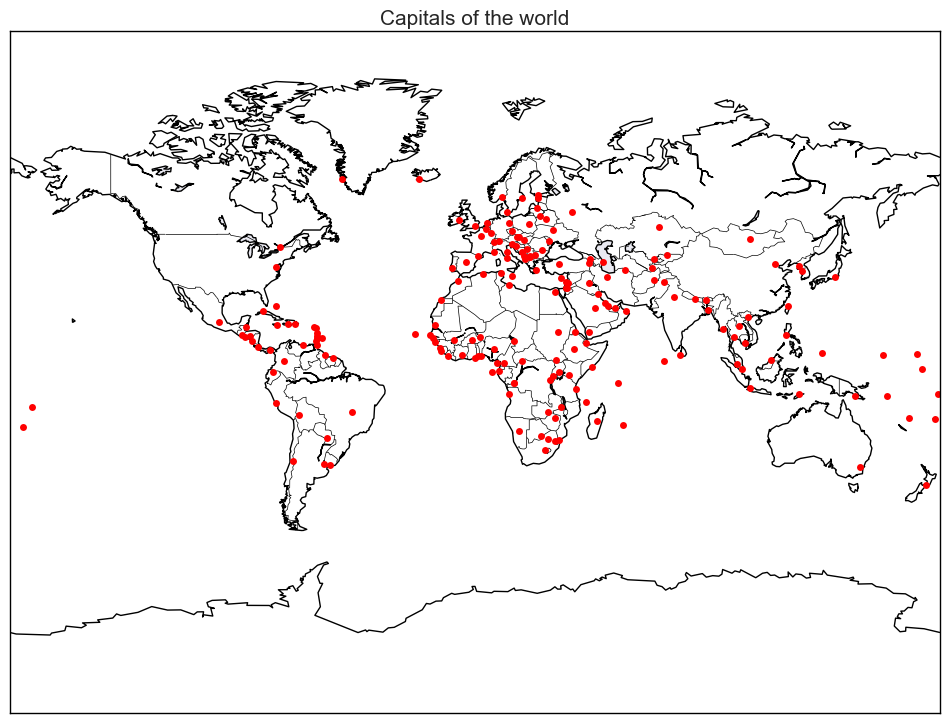

In [7]:
def convertodegrees(x):
    split_coordinates = str(x).split()
    num = float(split_coordinates[0])
    dec = float(split_coordinates[1])
    dec = dec/100
    coordinates =  num+dec
    if(split_coordinates[2] == 'S' or split_coordinates[2] == 'W'):
        coordinates = -1 * coordinates
    return coordinates

latindegrees = country["Latitude of Capital"].dropna().apply(convertodegrees)
lonindegrees = country["Longitude of Capital"].dropna().apply(convertodegrees)
lat = []
lon = []
for x in latindegrees:
    lat.append(x)
for y in lonindegrees:
    lon.append(y)    
    

fig = plt.figure(figsize=(12,12))
m = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color="white")
m.drawmapboundary(fill_color="white")
x,y = m(lon,lat)
m.plot(x, y,'ro', markersize=5)
plt.title("Capitals of the world",fontsize=15)

The visualization above shows the capital cities of all the 197 countries. It doesn't reveal anything special that a simple Atlas wouldn't do but does remind us of all the small island countries on the pacific ocean.

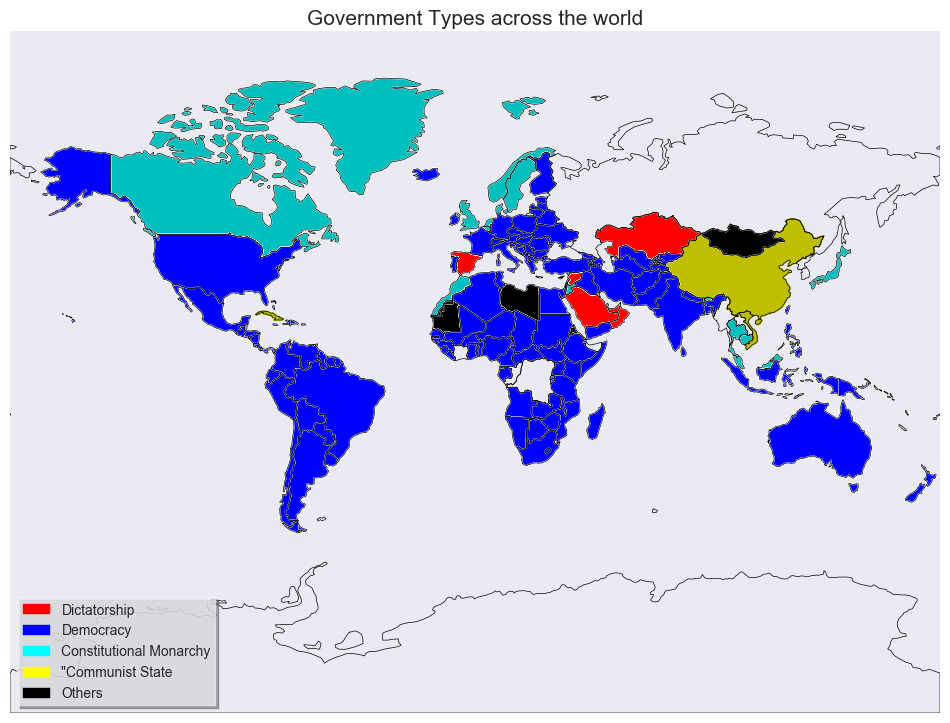

In [8]:
fig, ax= plt.subplots(figsize=(12,12))
d = country
d = d.set_index(d["Country Name"])
map = Basemap(projection='mill',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')

map.readshapefile("ne_110m_admin_0_countries", 'countries', drawbounds = True)

        
dem   = []
cm = []
dic = []
oth = []
cs = []
for country_name in d["Country Name"]:
    for info, shape in zip(map.countries_info, map.countries):
        if info['name_long'] == country_name:
            if d.loc[country_name]["Simplified Government Type"] == "Constitutional Monarchy":
                cm.append( Polygon(np.array(shape), True) )
                ax.add_collection(PatchCollection(cm, facecolor= 'c', edgecolor='w', linewidths=1., zorder=1,label="red"))
            elif d.loc[country_name]["Simplified Government Type"] == "Democracy":
                dem.append( Polygon(np.array(shape), True) )
                ax.add_collection(PatchCollection(dem, facecolor= 'b', match_original=False, edgecolor='w', linewidths=1., zorder=1))
            elif d.loc[country_name]["Simplified Government Type"] == "Dictatorship":
                dic.append( Polygon(np.array(shape), True) )
                ax.add_collection(PatchCollection(dic, facecolor= 'r', match_original=False, edgecolor='w', linewidths=1., zorder=1))
            elif d.loc[country_name]["Simplified Government Type"] == "Communist State":
                cs.append( Polygon(np.array(shape), True) )
                ax.add_collection(PatchCollection(cs, facecolor= 'y' ,edgecolor='y', linewidths=1., zorder=1))
            elif d.loc[country_name]["Simplified Government Type"] == "Others":
                oth.append( Polygon(np.array(shape), True) )
                ax.add_collection(PatchCollection(oth, facecolor= "k",edgecolor='w', linewidths=1., zorder=1))
            else:
                pass
            
red_patch = mpatches.Patch(color="red", label='Dictatorship')
blue_patch = mpatches.Patch(color="blue", label='Democracy')
yellow_patch = mpatches.Patch(color='yellow', label='"Communist State')
cyan_patch = mpatches.Patch(color='cyan', label='Constitutional Monarchy')
black_patch = mpatches.Patch(color='black', label='Others')


plt.legend(loc="lower left",frameon = True,framealpha=0.8,shadow=True,
           handles=[red_patch,blue_patch,cyan_patch,yellow_patch,black_patch])
plt.title("Government Types across the world",fontsize=15)
plt.show()

The above data map shows us the different government types across the world. No surprise to see that Democracy is the most popular form of government in the world. We do see some red in the Middle Eastern Region as expected, however it is not as prominent as it should be due to the scale of the smaller countries vs the entire world map.

Unfortunately, the Shapefile downloaded from <a href> www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/ </a> had some missing values because of which, all countries couldn't be plotted.

###### b) Labour Force vs Population (Scatter Plot)

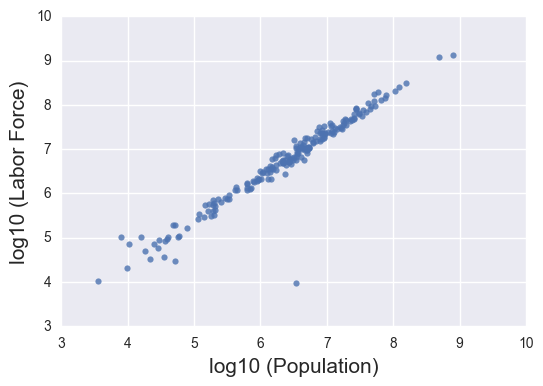

In [9]:
x1 = np.log10(country["Labor Force"])
y1 = np.log10(country["Population"])
sns.regplot(x=x1,y=y1,fit_reg=False,logx=True)
plt.xlabel("log10 (Population)", fontsize=15)
plt.ylabel("log10 (Labor Force)", fontsize=15)

The scatter plot of log(Labour Force) vs log(Population) reveals a linear relationship. It shows that more the population of a country, more the labour force it is likely to have. It is obvious intuitively, but the scatter plot backs up our intuition with data. This is why countries like China and India are some of the fastest growing nations in the world. They have a huge population and can afford a much larger labor force.

*Log was used to normalize Labor Force and Population values

###### c) Most Powerful Nations of the World (Bar)

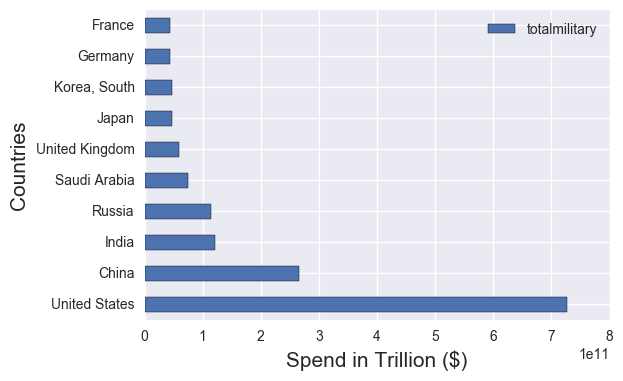

In [10]:
columns = ["Country Name", "Military Expenditure/GDP","GDP (PPP) in US $"]
data = pd.DataFrame(country, columns=columns)

# Get the absolute military spend by Multiplying Military Budget/gdp with gdp.
# Since Budget is supposed to be a fractional percentage of the gdp, we divide it by 100

data["totalmilitary"] = (country["Military Expenditure/GDP"]*(country["GDP (PPP) in US $"])/100)
data = data.sort_values(by="totalmilitary",ascending=False).head(10)
data.plot(kind="barh",x="Country Name",y=["totalmilitary"])
plt.xlabel("Spend in Trillion ($)", fontsize=15)
plt.ylabel("Countries", fontsize=15)

We can see from the above chart which are the 10 most powerful nations of the world. USA ranks at the top (no surprises). It beats all of its competitors by a huge margin. As a matter of fact, its military spend is greater than its nearest 5 countries combined. China and India thanks to its huge population and booming economy can too afford a high military spend albeit no where near USA.

###### d) Median life expectancy under different government systems

Earlier, in the data cleaning phase, we had reduced the different types of Governments into the nearest 5 categories. 
<br> Now in this box plot, we look at the median life expectancy of people living under different kinds of governance systems.
<br> Do people in Democracies live longer than Dictatorships on average?

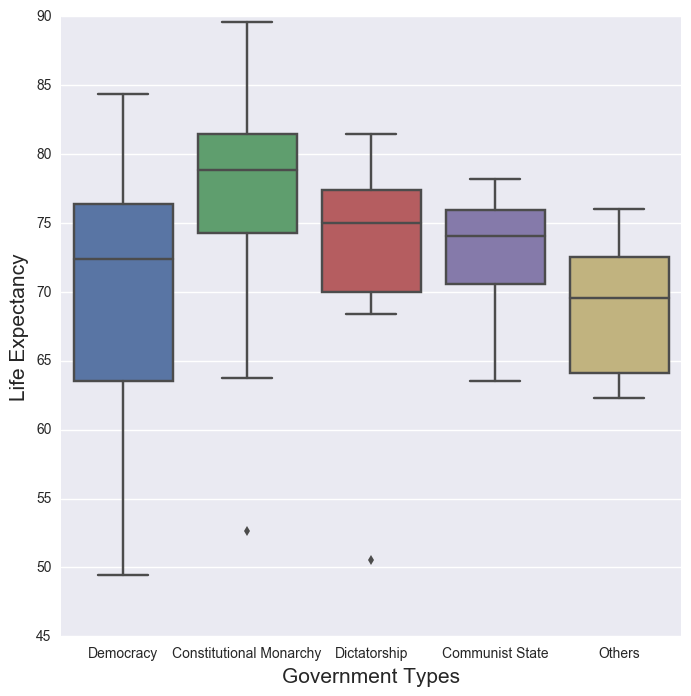

In [13]:
plt.figure(figsize=(8, 8))
sns.boxplot(country["Life Expectancy"], groupby=country["Simplified Government Type"])
plt.xlabel("Government Types", fontsize=15)
plt.ylabel("Life Expectancy", fontsize=15)

As expected, the median age of Life Expectancy for people living in a Democracy is higher than under a Dictatorship. However, it only does marginally better than a dictatorship government and is beaten by all other forms of governance.<br> <br>The real surprise here is Constitutional Monarchy governance system where on average people live much longer than people of all other forms of governance and that too by a huge margin. Expect, the Royal family of England to use this data to justify their existence in future!

###### e) Does money buy health? (Bar chart)

We find the 10 countries of the world that spend the most money (absolute, not relative to its GDP) on health and compare it against the Life Expectancy of its people.
<br><br>
We divide the total health spend by 10^10, to bring it to the same scale as Life Expectancy (in 2 digits)

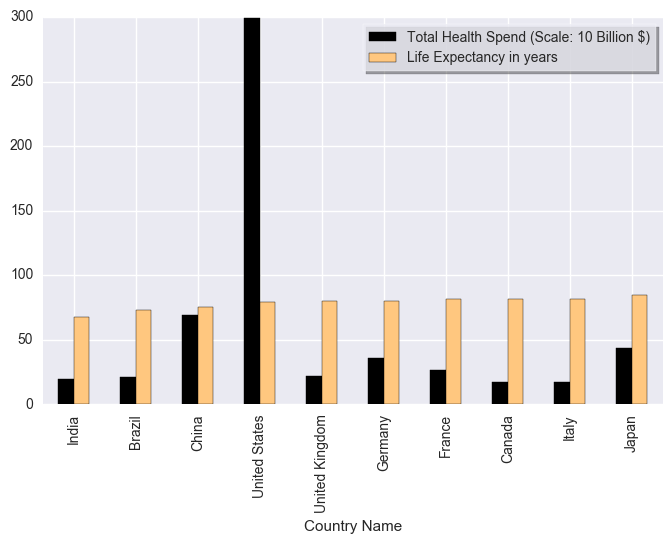

In [14]:
columns = ["Country Name","Health Expenditure/GDP", "Life Expectancy","GDP (PPP) in US $"]
data = pd.DataFrame(country, columns=columns)
data["totalhealth"] = (country["Health Expenditure/GDP"]*(country["GDP (PPP) in US $"])/100)/10000000000

data = data.sort_values(by="totalhealth",ascending=False).head(10)
data = data.sort_values(by="Life Expectancy")

data.plot(kind="bar",x="Country Name",y=["totalhealth","Life Expectancy",],sort_columns=True,
          colormap="copper",figsize=(8,5))
plt.legend(loc="upper right",frameon = True,framealpha=0.8,shadow=True,
           labels=("Total Health Spend (Scale: 10 Billion $)","Life Expectancy in years"))

As expected, money doesn't buy health. USA spend a whopping amount of money on healthcare but the life expectancy of its people is no better than people of other countries with far lesser spend. Italy shows an amazing ROI (Return on investment) . Even with a very small (relative to other countries) amount of money allocated towards health, its people live a long life. 
<br><br> Japan tops the list here for the highest life expectancy amongst the top 10 countries which spend very high on Healthcare

<center><h1> ------ </h1></center>
## Pearson Correlation Analysis
#### (2) Do a pairwise Pearson correlation analysis on all valid pairs of variables. 
Find out most positive and negative correlations.
Do a permutation test to determine the p­values of these 2 correlations to test which are significant 
(what fraction of permutations produce at least this high a correlation).

In [15]:
r_values = country.corr(method="pearson")
r_values

,Population,Life Expectancy,GDP (PPP) in US $,Area (sq km),Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate,Age of Country
Population,1.000000,0.014249,0.697280,0.453228,0.575146,0.120474,-0.045319,-0.069309,0.054278,0.436312,0.004341,0.980434,0.762590,-0.042241,-0.014170
Life Expectancy,0.014249,1.000000,0.175071,0.033022,-0.219494,0.162933,0.716177,0.120447,-0.049039,0.065346,0.132156,0.034308,0.157256,-0.441207,0.311041
GDP (PPP) in US $,0.697280,0.175071,1.000000,0.592445,0.500468,0.204414,0.121587,0.194862,0.124006,0.480106,0.033150,0.730154,0.940162,-0.176152,0.050991
Area (sq km),0.453228,0.033022,0.592445,1.000000,0.749098,0.521336,0.048099,0.065444,0.161624,0.760845,0.038194,0.477289,0.566274,-0.026215,-0.005119
Land Boundaries (km),0.575146,-0.219494,0.500468,0.749098,1.000000,0.195977,-0.154284,-0.109299,0.172682,0.672572,0.001567,0.581087,0.528291,0.138093,-0.030689
Coastline (km),0.120474,0.162933,0.204414,0.521336,0.195977,1.000000,0.132488,0.109379,-0.024803,0.377024,0.040946,0.124275,0.177264,-0.138469,0.013964
Literacy Rate (%),-0.045319,0.716177,0.121587,0.048099,-0.154284,0.132488,1.000000,0.135111,-0.096622,0.068230,0.042167,-0.009881,0.115765,-0.325159,0.146071
Health Expenditure/GDP,-0.069309,0.120447,0.194862,0.065444,-0.109299,0.109379,0.135111,1.000000,-0.125568,0.044190,-0.000699,-0.055958,0.132715,-0.121556,0.122184
Military Expenditure/GDP,0.054278,-0.049039,0.124006,0.161624,0.172682,-0.024803,-0.096622,-0.125568,1.000000,0.044575,0.175252,0.044461,0.086076,-0.050186,-0.041180
Renewable Water Resources (cu km),0.436312,0.065346,0.480106,0.760845,0.672572,0.377024,0.068230,0.044190,0.044575,1.000000,0.015602,0.447040,0.485615,0.119153,0.046902


From the correlation matrix, we can see that -
<br>
Population and Labour Force are the most positively correlated with a r value of 0.98 <br>
and <br>
Life Expectancy and Commercial Prime Lending are the most negatively correlated with a r value of -0.44

In [16]:
x = country["Population"]
y = country["Labor Force"]
pearson = pearsonr(x, y)
print("Most Highly Correlated - Population and Labor Force")
print("Correlation coefficient :{}, P Value: {}".format(pearson[0],pearson[1]))

x = country["Life Expectancy"]
y = country["Commercial Prime Lending Rate"]
pearson = pearsonr(x, y)
print("Most Negatively Correlated - Life Expectancy and Commercial Prime Lending Rate")
print("Correlation coefficient :{}, P Value: {}".format(pearson[0],pearson[1]))

Most Highly Correlated - Population and Labor Force
Correlation coefficient :0.980434371188, P Value: 1.31719318287e-139
Most Negatively Correlated - Life Expectancy and Commercial Prime Lending Rate
Correlation coefficient :-0.441207388835, P Value: 8.62590277952e-11


###### Permutation Tests

Values above the Observed Pearson Coefficient = 0, values below = 9999
The distribution of Correlation coefficients with respect to the originally observed co-efficient is as follows:
Since we saw only one Correlation coefficient to be as high as 0.98 (the original value), we can conclude that the p value = 1/10000 = 0.0001


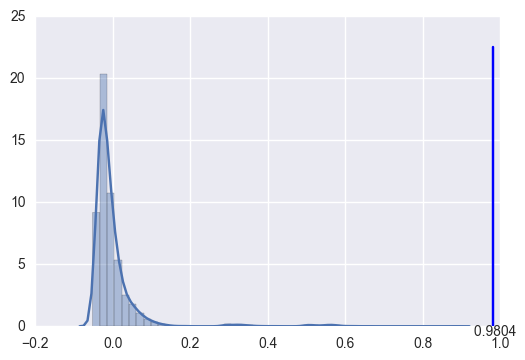

In [17]:
above = 0
below = 0
perm_values = []
for i in range(9999):
    permutation_life = country["Population"].sample(frac=1)
    y = country["Labor Force"]
    pearson = pearsonr(permutation_life , y)
    perm_values.append(pearson[0])
    if(pearson[0] > 0.98043437118759902):
        above+=1
    else:
        below+=1

print("Values above the Observed Pearson Coefficient = {}, values below = {}".format(above,below))
print("The distribution of Correlation coefficients with respect to the originally observed co-efficient is as follows:")
sns.distplot(perm_values)
plt.axvline(x=0.980434371188,ymax=0.9)
plt.text(0.980434371188,-0.4,' 0.9804',horizontalalignment='center',verticalalignment='center')
print("Since we saw only one Correlation coefficient to be as high as 0.98 (the original value), we can conclude that the p value = 1/10000 = 0.0001")

Values above the Observed Pearson Coefficient = 9999.0, values below = 0.0
The distribution of Correlation coefficients with respect to the originally observed co-efficient is as follows:
Since we saw only one Correlation coefficient to be as high as -0.44 (the original value), we can conclude that the p value = 1/10000 = 0.0001


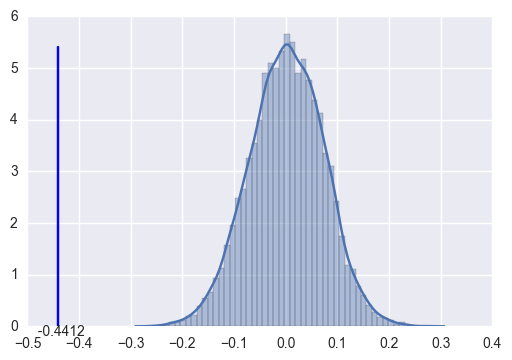

In [18]:
above = 0.0
below = 0.0
perm_values = []
for i in range(9999):
    permutation_life = country["Life Expectancy"].sample(frac=1)
    y = country["Commercial Prime Lending Rate"]
    pearson = pearsonr(permutation_life , y)
    perm_values.append(pearson[0])
    if(pearson[0] > -0.44120738883508565):
        above+=1
    else:
        below+=1
print("Values above the Observed Pearson Coefficient = {}, values below = {}".format(above,below))
print("The distribution of Correlation coefficients with respect to the originally observed co-efficient is as follows:")
sns.distplot(perm_values)
plt.axvline(x=-0.441207388835,ymax=0.9)
plt.text(-0.44120738883508565,-0.1,'  -0.4412',horizontalalignment='center',verticalalignment='center')
print("Since we saw only one Correlation coefficient to be as high as -0.44 (the original value), we can conclude that the p value = 1/10000 = 0.0001")

<center><h1> ------ </h1></center>
## Linear Regression

#### 3 )Set up a simple linear regression model to predict the average income (GDP per capita) as a function of other individual variables. 
Among all options, which model minimizes the squared error? 
Under this model, which countries are most above the forecast? Which are most below? Can you explain why?

In [26]:
percapita = ((country["GDP (PPP) in US $"]) / country["Population"])
percapita.head()

0     1423.505527
1     9383.456575
2     7335.034759
3    37012.333544
4     6904.823349
dtype: float64

In [28]:
# Get Linear Regression of All attributes vs GDP Per Capita and store them in a Panda Data Frame for easy viewing

headers = ["Attribute vs GDP per capita", "Intercept Value", "Slope", " Coefficient of Determination", "Mean Square Error"]
regressiondata = []
for column in country:
    if(country[column].dtype == np.float64 or country[column].dtype == np.int64):
        per_row = []
        x = country[column]
        # Take Log for normalization
        x = np.log10(x) 
        # Replace any odd values that might creep up because of taking logs (such as log of zero)
        x.replace(to_replace=[np.inf,-np.inf,np.NaN],value=0,inplace=True)
        # Take Log for normalization
        y = np.log10(percapita) 
        # Replace any odd values that might creep up because of taking logs (such as log of zero)
        y.replace(to_replace=[np.inf,-np.inf,np.NaN],value=0,inplace=True)
        model = LinearRegression()
        model.fit(x.reshape(-1,1),y)
        per_row.extend((column, model.intercept_, model.coef_[0], 
                      model.score(x.reshape(-1,1),y), mean_squared_error(model.predict(x.reshape(-1,1)),y)))
        regressiondata.append(per_row)

regression = pd.DataFrame(data = regressiondata,columns=headers)
# Sort by least mean square error
regression.sort_values(by="Mean Square Error")

,Attribute vs GDP per capita,Intercept Value,Slope,Coefficient of Determination,Mean Square Error
1,Life Expectancy,-9.435172,7.232475,0.588019,0.124445
6,Literacy Rate (%),-1.964057,3.067561,0.453378,0.165116
13,Commercial Prime Lending Rate,4.999733,-1.124219,0.305142,0.209893
2,GDP (PPP) in US $,1.894472,0.189494,0.120295,0.265729
14,Age of Country,3.070815,0.453932,0.084952,0.276405
12,Internet Users (circa 2009),3.028419,0.148704,0.077317,0.278711
5,Coastline (km),3.698922,0.091576,0.055857,0.285194
4,Land Boundaries (km),4.156235,-0.092319,0.055378,0.285338
3,Area (sq km),4.428718,-0.105415,0.053237,0.285985
10,Net Migration Rate/1000 Population,3.876802,0.315985,0.052297,0.286269


According to this chart, Life Expectancy produces the best model with the least mean square error.<br><br>
Next we produce the actual prediction value under this model and compare it against the actual value. Finally, we sort the table by difference of values to see which are the most above forecase and which ones are the most below

In [29]:

x = country["Life Expectancy"]
y = percapita
model = LinearRegression()
model.fit(x.reshape(-1,1),y)
prediction = model.predict(x.reshape(-1,1))
difference = prediction-y
columns = [x,y,prediction,difference]
a = pd.DataFrame()
a["Country Name"] = country["Country Name"]
a["Life Expectancy"] = country["Life Expectancy"]
a["prediction"] = prediction
a["Actual GDP per capita"] = percapita
a["difference"] = prediction-y
a = a.sort_values(by="difference")
print("Top 3")
display(a.head(3))
print("Bottom 3")
display(a.tail(3))

Top 3


,Country Name,Life Expectancy,prediction,Actual GDP per capita,difference
116,Monaco,89.57,42341.118701,203651.501246,-161310.382544
141,Qatar,78.38,26892.602561,93586.917613,-66694.315052
100,Liechtenstein,81.68,31448.465230,85760.994828,-54312.529598


Bottom 3


,Country Name,Life Expectancy,prediction,Actual GDP per capita,difference
164,Sri Lanka,76.35,24090.056738,6150.976988,17939.079750
119,Morocco,76.51,24310.947049,5456.660985,18854.286064
159,Solomon Islands,74.89,22074.432648,3210.451841,18863.980807


Countries like Monaco, Liechtenstein, Qatar which have a very high GDP per capita lie above the forecast ,whereas <br>
countires like Solomon Islands, Morocco and Sri Lanka lie below the forecast.
<br><br> Amongst these, Monaco and Solomon Islands are the most above and below the prediction. This is due to the fact, that the cartesian coordinate points of Monaco and Solomon Islands on a X-Y plane lie the most above and below the best fit linear regression line.
<br><br>
This is demonstrated below with the aid of a scatter plot along with the best fit regression line. The coordinates of Monaco and Solomon Islands are highlighted to show how far they lie from the best fit regression line.

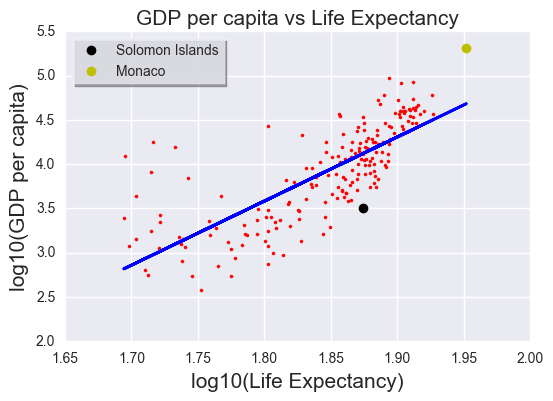

In [30]:
x = np.log10(country["Life Expectancy"])
y = np.log10(percapita)
model = LinearRegression()
model.fit(x.reshape(-1,1),y)
prediction = model.predict(x.reshape(-1,1))
plt.scatter(x, y, color='r', marker=".")
plt.plot(x, prediction, color='blue', linewidth=2)
plt.xlabel("log10(Life Expectancy)", fontsize=15)
plt.ylabel("log10(GDP per capita)", fontsize=15)
plt.title("GDP per capita vs Life Expectancy", fontsize = 15)
plt.plot(np.log10(74.89),np.log10(3210.451841),"ko", label="Solomon Islands") 
plt.plot(np.log10(89.57),np.log10(203651.501246),"yo", label = "Monaco")
plt.legend(loc="upper left",frameon = True,framealpha=0.8,shadow=True)

<center><h1> ------ </h1></center>
## Scoring / Ranking Function
#### (4) Set up a scoring/ranking function to measure general social welfare. 
Which countries do best by your measure? Which do worst? 
Write a few paragraphs to describe your measure and evaluate how good/bad you think the results are.
<br><br>

According to Professor Skiena's book, a good ranking function has the properties of simplicity, relevance and its frequency distribution resembles a bell curve.
<br>

We take only the relevant variables which can be predictive of the social welfare of a country after normalizing them:
- <b>GDP per capita:</b> After taking logarithm of the per capita value, it is observed that its values range between (1-5), so we multiply it by 20 (chosen after many mathematical hit and trials to get the best result) and finally normalize the result once again with a log function
- <b>Literacy rate</b> : Normalized by taking logarithm
- <b>Life Expectancy</b> :  Normalized by taking logarithm
- <b>Total Health Budget</b> : We first convert Health exenditure/GDP to percentage by dividing by 100, then multiply by actual GDP to get the absolute health spend in \$. Then we divide it by 10^11 to reduce it to two digits. Then we take its logarithm.
- <b>Total Military Budget</b> We first convert Military exenditure/GDP to percentage by dividing by 100, then multiply by actual GDP to get the absolute military spend in \$ . Then we divide it by 10^11 to reduce it to two digits. Then we take its logarithm.

In [31]:
gdpnormalized = np.log10(np.log10(percapita)*20)
logliteracy = np.log10(country["Literacy Rate (%)"])
loglifeexpectancy = np.log10(country["Life Expectancy"])
totalhealth = (country["Health Expenditure/GDP"]*(country["GDP (PPP) in US $"])/100)/100000000000
totalmilitary = (country["Military Expenditure/GDP"]*(country["GDP (PPP) in US $"])/100)/100000000000
loghealth = np.log10(totalhealth)
logmilitary = np.log10(totalmilitary)

cols = [gdpnormalized,logliteracy,loglifeexpectancy,loghealth,logmilitary]
a = pd.DataFrame(data=country["Country Name"])
a["gdpnormalized"] = gdpnormalized
a["logliteracy"] = logliteracy
a["loglifeexpectancy"] = loglifeexpectancy
a["loghealth"] = loghealth
a["logmilitary"] = logmilitary
a.head()

,Country Name,gdpnormalized,logliteracy,loglifeexpectancy,loghealth,logmilitary
0,Afghanistan,1.799803,1.448706,1.703205,-1.361631,-1.668123
1,Albania,1.900079,1.985875,1.891872,-1.748260,-2.380283
2,Algeria,1.888225,1.860937,1.883037,-0.954548,-0.894335
3,Andorra,1.960789,2.000000,1.917243,-2.642568,-3.332583
4,Angola,1.885265,1.847573,1.742647,-1.336017,-1.320178


In [32]:
# Replace infinity values that might arise because of taking Logarithm of 0
a.replace(to_replace=[np.inf,-np.inf],value=0,inplace=True) 
a["score"] = a["gdpnormalized"] + a["logliteracy"] + a["loglifeexpectancy"] + a["loghealth"] + a["logmilitary"]
print("Top 5 Countries that rank the best")
display(a.sort_values(by="score",ascending=False).head(5))
print("Bottom 5 Countries that rank the worst")
display(a.sort_values(by="score",ascending=False).tail(5))

Top 5 Countries that rank the best


,Country Name,gdpnormalized,logliteracy,loglifeexpectancy,loghealth,logmilitary,score
187,United States,1.974934,1.995635,1.900695,1.476089,0.861726,8.209079
35,China,1.902505,1.978181,1.875929,0.842784,0.425634,7.025032
84,Japan,1.961004,1.995635,1.926651,0.643252,-0.329595,6.196947
63,Germany,1.963819,1.995635,1.905472,0.554122,-0.360867,6.058181
143,Russia,1.929759,1.998695,1.846090,0.199443,0.057358,6.031344


Bottom 5 Countries that rank the worst


,Country Name,gdpnormalized,logliteracy,loglifeexpectancy,loghealth,logmilitary,score
37,Comoros,1.788847,1.877947,1.802637,-3.316206,-3.873164,-1.719939
150,Sao Tome and Principe,1.825368,1.841985,1.807670,-3.489227,-4.208401,-2.222605
133,Palau,1.909984,1.963788,1.860937,-3.584643,-4.442631,-2.292565
123,Nauru,1.880925,1.970812,1.822168,-4.230623,-5.054531,-3.611249
182,Tuvalu,1.853620,1.970812,1.818292,-4.159894,-5.230623,-3.747793


###### Social Welfare rank of a country =
###### log_10(log_10(gdp/capita)*20) + log_10(Literacy Rate) + log_10(Life Expectancy) +  log_10(Total Health Spend) + log_10(Total Military Spend)

According to the above scoring function we get countries like USA, China, Japan, Germany and Russia in the top 5 and 
Comoros, Sao Tome and Principe, Palau, Nauru and Tuvalu in the bottom 5.

count    197.000000
mean       1.938045
std        2.140369
min       -3.747793
25%        0.429545
50%        1.841988
75%        3.587832
max        8.209079
Name: score, dtype: float64

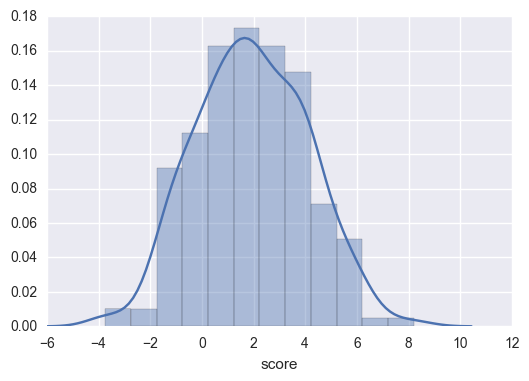

In [33]:
sns.distplot(a["score"])
a["score"].describe()

The frequency distribution of the scoring function gives a bell curve distribution which is one of the characteristics of a good scoring function.
<br><br>
Next, we can check the z_scores from this scoring function to evaluate for outliers and validate that all values lie within 2 Standard Deviations or not.

count    1.970000e+02
mean     2.028834e-17
std      4.672092e-01
min     -1.241130e+00
25%     -3.292821e-01
50%     -2.096771e-02
75%      3.601230e-01
max      1.368869e+00
Name: z_score, dtype: float64

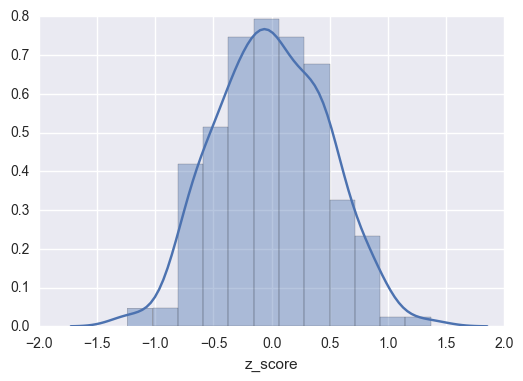

In [34]:
a["z_score"] = (a["score"] - a["score"].mean())/a["score"].var()
sns.distplot(a["z_score"])
a["z_score"].describe()

The Z score distribution is also that of a bell curve. 

<b> Things that model gets right: </b>

- The model produces a scoring function is easy to understand and compute.
- The scoring function has a good frequency distribution resembling a bell curve.
- The function also uses normalizations of variables to take care of outliers. 
- The top 5 and bottom 5 countries produces from this scoring function make intuitive sense (i.e. they look correct)

<b>Things that model can improve upon: </b>

- The model ranks countries on the basis of military muscle, GDP, Health spend etc. It places too much importance on the financial health of the countries and ignores the social aspects such as social equality, quality of life, gross happiness index, freedom of its citizen etc. due to unavailability of data. Therefore Nordic countries like Norway, Sweden, Finland which are supposed to have a great social welfare scheme for its citizen find themselves missing from the top 10.

<center><h1> ------ </h1></center>
## Distance Function
#### (5) Set up a meaningful distance function to measure how similar/difference pairs of countries are. 
Produce a table showing the nearest and farthest neighbor to each nation on earth? 
Write a short analysis of this table describing: (a) What kinds of similarities does your measure get right? 
(b) What are the most interesting/surprising pairs to fall out of this analysis? 
and (c) Where does it goof up?

<br><br>
If we assume all the data points to be coordinates on a cartesian plane, then we can find the distance between any two countries, by finding the euclidean distance between them.

The data points on which countries are compared are the following:
<br>

 GDP , Total Health spend, Total Military Spend, Population, Area, Water Resources, Labor Force Available, Internet Users, Total Literate Population, Commerical Prime Lending Rate, Government Type
<br>

<b> Normalization </b>: All values are considered in their Logarithm Scale. Few data points were considered which were not available in the given data set. They were calculated as follows:

- <b> Government Type</b>: Earlier, in the data cleaning phase, all the different government types were reduced to 5 categories. Simliar countries should have similar government types. So they are converted to numerical scale. Democracy and Dictatorship are at the opposite end of the spectrum. So, Democracy is mapped to 1 while Dictatorship is mapped to 3 to produce some distance between them. Constitutional Monarchy is simliar to Democracy except there is a figurehead king/queen. So it is mapped to 1.5 to bring it closer to Democracy but not equal to it. Communist state is mapped to 2 while governments which are of category 'Others' are mapped to value 2.5

- <b> Total Literate Population</b>: Evaluated by mulitplying Literacy Rate * Population

- <b>Total Health Budget</b> : Evaluated by converting Health exenditure/GDP to percentage by dividing by 100, then multiplying by actual GDP to get the absolute health spend in \$. Then we divide it by 10^11 to reduce it to two digits.

- <b>Total Military Budget</b> Evaluated by converting Military exenditure/GDP to percentage by dividing by 100, then multiplying by actual GDP to get the absolute military spend in \$ . Then we divide it by 10^11 to reduce it to two digits.




In [35]:
q = pd.DataFrame(data=country["Country Name"])
q["loglifeexpectancy"] = np.log10(country["Life Expectancy"])
q["logtotalhealth"] = np.log10(totalhealth)
q["logtotalmilitary"] = np.log10(totalmilitary)
q["logpopulation"] = np.log10(country["Population"])
q["loggdp"] = np.log10(country["GDP (PPP) in US $"])
q["logarea"] = np.log10(country["Area (sq km)"])
q["logwaterresource"] = np.log10(country["Renewable Water Resources (cu km)"])
q["loglaborforce"] = np.log10(country["Labor Force"])
q["loginternetusers"] = np.log10(country["Internet Users (circa 2009)"])
q["logliteratepopulation"] = np.log10((country["Literacy Rate (%)"]/100)*country["Population"])
q["Commercial Prime Lending Rate"] = np.log10(country["Commercial Prime Lending Rate"])
gov = {"Democracy": 1, "Constitutional Monarchy": 1.5 , "Communist State": 2 , "Dictatorship": 3, "Others": 2.5}
q['govpoints'] = country["Simplified Government Type"].map(gov)

# Replace any infinities that may have arised due to taking log(0), and replace them with 0.
q.replace(to_replace=[np.inf,-np.inf],value=0,inplace=True) 

# Replace the miliatry budget of Kuwait to the median value of the column.
# Currently, the military budget of Kuwait is 0. This can be attributed to error in data collection.
q.set_value(92,"logtotalmilitary",q["logtotalmilitary"].median())
q.head()

,Country Name,loglifeexpectancy,logtotalhealth,logtotalmilitary,logpopulation,loggdp,logarea,logwaterresource,loglaborforce,loginternetusers,logliteratepopulation,Commercial Prime Lending Rate,govpoints
0,Afghanistan,1.703205,-1.361631,-1.668123,7.502739,10.656098,5.814401,1.815113,6.875756,6.000000,6.951445,1.176091,1.0
1,Albania,1.891872,-1.748260,-2.380283,6.480037,10.452400,4.458608,1.620136,6.040602,6.113943,6.465912,0.978637,1.0
2,Algeria,1.883037,-0.954548,-0.894335,7.588985,11.454387,6.376895,1.067071,7.047275,6.672098,7.449922,0.903090,1.0
3,Andorra,1.917243,-2.642568,-3.332583,4.931753,9.500099,2.670246,1.776701,4.557026,4.826723,4.931753,0.997386,1.0
4,Angola,1.742647,-1.336017,-1.320178,7.280763,11.119915,6.095762,2.170262,6.955110,5.782974,7.128335,1.176091,1.0


In [36]:
q = q.drop(["Country Name"],axis=1)
# Convert to arrays
z = np.array(q) 

# Apply euclidean distance formula on all the variables and get the values in squareform
d = squareform(pdist(z, 'euclidean')) 
# Make a dataframe out of the result for easy viewing
d = pd.DataFrame(data = d,columns=[country["Country Name"]])
d.index = country["Country Name"]

# 0.00 is the distance of one country with itself. So, it is replaced with NaN. 
d.replace(to_replace=0.0000,value=np.NaN,inplace=True)
print("Distance Matrix of first five country with respect to all the other countries")
d.head()

Distance Matrix of first five country with respect to all the other countries


Country Name,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,2.154309,1.766810,5.758013,0.823201,6.808511,2.577794,2.389445,2.850366,2.077964,...,6.044341,1.470495,1.061217,5.175569,2.091221,2.816575,4.608352,1.591786,1.001531,1.764806
Albania,2.154309,NaN,3.369934,3.800796,2.609472,5.051933,4.094261,1.195202,4.336638,2.350389,...,7.532199,1.169336,2.470270,3.611920,3.441649,4.112744,3.429326,2.529007,1.879647,1.856259
Algeria,1.766810,3.369934,NaN,7.062252,1.681217,7.731014,2.145322,3.534512,2.097439,2.191344,...,4.969798,2.682794,1.410805,6.613432,2.196809,2.601595,5.863244,1.613010,2.525101,3.039680
Andorra,5.758013,3.800796,7.062252,NaN,6.110661,3.169977,7.683859,3.771165,7.874318,5.803644,...,11.028998,4.634884,6.250940,1.947014,6.978841,7.663792,3.713596,6.056941,5.294962,5.002556
Angola,0.823201,2.609472,1.681217,6.110661,NaN,7.297278,2.207324,2.822697,2.428345,2.143604,...,5.637681,1.706867,1.309313,5.530778,1.760318,2.643696,5.028942,2.044674,1.445061,2.377184


In [37]:
# Produce a data frame which reveals the most similar country & most dissimilar countries for each country
headers = ["Country Name","Most Similar Country", "Most Dissimilar Country" ]
table = []
for column in d:
    per_row = []
    nameofcountry = column
    nearest = d[column].argmin()
    farthest = d[column].argmax()
    per_row.extend((nameofcountry,nearest,farthest))
    table.append(per_row)
table = pd.DataFrame(data=table,columns=headers)
pd.set_option('display.max_rows', 200)
table

,Country Name,Most Similar Country,Most Dissimilar Country
0,Afghanistan,Angola,Tuvalu
1,Albania,Bosnia and Herzegovina,China
2,Algeria,South Africa,Tuvalu
3,Andorra,Seychelles,China
4,Angola,Afghanistan,Tuvalu
5,Antigua and Barbuda,Saint Kitts and Nevis,China
6,Argentina,Colombia,Tuvalu
7,Armenia,Macedonia,China
8,Australia,Argentina,Tuvalu
9,Austria,Switzerland,Tuvalu


<b>(a) What kinds of similarities does your measure get right?</b>

Countries that are similar to each other in terms of size, population and economy are predicted as similar to each other by this model. For instance it shows India and Brazil as similar countries. Both are large countries, with booming economies and large population and the distance function does rank them as most similar. Other pair of countries which the model gets right are Sweden - Norway, Qatar- Kuwait, Switzerland	- Austria, France - Germany etc.


<b>(b)What are the most interesting/surprising pairs to fall out of this analysis?  </b>

The analysis ranks China to be the most similar country to United States. In terms of culture, they couldn't be further apart (one is a free market democractic country, while the other is a communist country) but if you look at the economy, size and military muscle of the two countries, one is bound to say that they are similar to each other.

The model also finds North Korea and Syria to be similar to each other. If you look at the probability of your survivial in either countries in today's time, then you are bound to agree that both of them are indeed similar to each other.

<b>(c) Where does it goof up?</b>

The model predicts China and Tuvalu to be dissimilar to most other countries. This is probably because the metrics for China are in the top 5% for each of the data points considered such as Population, Area, GDP, Military strength etc. On the other hand Tuvalu - a small country of only 26sq Km is in the bottom 5% for all the data points considered. As a result, China and Tuvalu end up alienating all the other countries of the world and are predicted to be most dissimilar to other countries. 

## References

- Python hackings

http://stackoverflow.com/questions/15851568/how-to-get-the-last-part-of-a-string-before-a-certain-character


- Panda hacks: 

http://stackoverflow.com/questions/39564372/create-new-column-in-pandas-based-on-value-of-another-column/39566156-39566156


- Linear Regression

https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
https://github.com/viveksck/data_science_course/blob/master/ML.ipynb

- Plots and Matlab

http://matplotlib.org/users/legend_guide.html
http://stackoverflow.com/questions/13397022/fill-countries-in-python-basemap
http://basemaptutorial.readthedocs.io/en/latest/shapefile.html

- Theoretical References

The Data Science Design Manual by Steven S. Skiena
